# Toy problem with two theories

In [1]:
import numpy as np
import logging
import matplotlib
from matplotlib import pyplot as plt
from pylab import legend
%matplotlib inline

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)
        
from madminer import sampling
from madminer.sampling import SampleAugmenter
from madminer.ml import ParameterizedRatioEstimator
from madminer.core import MadMiner
from scipy.stats import poisson
from madminer.delphes import DelphesReader
from madminer.sampling import combine_and_shuffle

def calculate_invariant_mass(all_x):
    """Calculates invariant mass given jet four-momenta."""
    eta0 = all_x[:,0]
    phi0 = all_x[:,1]
    pt0  = all_x[:,2]
    m0   = all_x[:,3]
    eta1 = all_x[:,4]
    phi1 = all_x[:,5]
    pt1  = all_x[:,6]
    m1   = all_x[:,7]
    return  np.sqrt(2 * np.abs(pt0) * np.abs(pt1) * (np.cosh(eta0 - eta1) - np.cos(phi0-phi1)))

def twod_data(all_x):
    """Calculates an array containing the invariant mass and y_jj given jet four-momenta."""
    invm = calculate_invariant_mass(all_x)
    eta0 = all_x[:,0]
    phi0 = all_x[:,1]
    pt0  = all_x[:,2]
    m0   = all_x[:,3]
    eta1 = all_x[:,4]
    phi1 = all_x[:,5]
    pt1  = all_x[:,6]
    m1   = all_x[:,7]
    delta_yjj = eta0 - eta1
    return np.concatenate([invm[:,None], delta_yjj[:,None]], axis=1)

02:32 madminer             INFO    
02:32 madminer             INFO    ------------------------------------------------------------------------
02:32 madminer             INFO    |                                                                      |
02:32 madminer             INFO    |  MadMiner v0.4.9                                                     |
02:32 madminer             INFO    |                                                                      |
02:32 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
02:32 madminer             INFO    |                                                                      |
02:32 madminer             INFO    ------------------------------------------------------------------------
02:32 madminer             INFO    


In [2]:
def increase_bin_points(plot_domain, bin_edges, bin_vals):
    plot_range = np.zeros(plot_domain.shape)
    for i in range(plot_range.shape[0]):
        for j in range(bin_edges.shape[0]-1):
            if plot_domain[i] >= bin_edges[j] and plot_domain[i] < bin_edges[j+1]:
                plot_range[i] = bin_vals[j]
    return plot_range

def evaluate_avg_within_each_bin(invm, logr, bin_edges):
    discrete_logr_med = np.zeros(bin_edges.shape[0] - 1)
    for j in range(bin_edges.shape[0]-1):
        logr_bin = logr[np.where((invm >= bin_edges[j]) * (invm < bin_edges[j+1]))[0]]
        discrete_logr_med[j] = np.sum(logr_bin) / float(logr_bin.shape[0])        
    return discrete_logr_med

In [3]:
sampler = SampleAugmenter('meta/delphes_data_shuffled_g02.h5')

# Draw Training Samples
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler.sample_train_ratio(
    theta0=sampling.benchmark('benchmark_27'), # 285.0, 1.0
    theta1=sampling.benchmark('benchmark_93'), # 315.0, 1.0
    n_samples=1000000,
    folder='./meta/samples',
    filename='train_ratio',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

02:33 madminer.analysis    INFO    Loading data from meta/delphes_data_shuffled_g02.h5
02:33 madminer.analysis    INFO    Found 2 parameters
02:33 madminer.analysis    INFO    Did not find nuisance parameters
02:33 madminer.analysis    INFO    Found 121 benchmarks, of which 121 physical
02:33 madminer.analysis    INFO    Found 8 observables
02:33 madminer.analysis    INFO    Found 649198 events
02:33 madminer.analysis    INFO      4123 signal events sampled from benchmark benchmark_1
02:33 madminer.analysis    INFO      4132 signal events sampled from benchmark benchmark_2
02:33 madminer.analysis    INFO      4454 signal events sampled from benchmark benchmark_3
02:33 madminer.analysis    INFO      4797 signal events sampled from benchmark benchmark_4
02:33 madminer.analysis    INFO      5488 signal events sampled from benchmark benchmark_5
02:33 madminer.analysis    INFO      6245 signal events sampled from benchmark benchmark_6
02:33 madminer.analysis    INFO      6973 signal events 

02:33 madminer.analysis    INFO      5975 signal events sampled from benchmark benchmark_94
02:33 madminer.analysis    INFO      6652 signal events sampled from benchmark benchmark_95
02:33 madminer.analysis    INFO      7280 signal events sampled from benchmark benchmark_96
02:33 madminer.analysis    INFO      7832 signal events sampled from benchmark benchmark_97
02:33 madminer.analysis    INFO      8212 signal events sampled from benchmark benchmark_98
02:33 madminer.analysis    INFO      4063 signal events sampled from benchmark benchmark_100
02:33 madminer.analysis    INFO      4122 signal events sampled from benchmark benchmark_101
02:33 madminer.analysis    INFO      4285 signal events sampled from benchmark benchmark_102
02:33 madminer.analysis    INFO      4655 signal events sampled from benchmark benchmark_103
02:33 madminer.analysis    INFO      5252 signal events sampled from benchmark benchmark_104
02:33 madminer.analysis    INFO      5917 signal events sampled from benchm

In [7]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(12,12,12),
)
train_loss, val_loss = estimator.train(
    method='alice',
    theta=theta0_2,
    x=x_2,
    y=y_2,
    
    r_xz=r_xz_2,
    initial_lr = .0022,
    final_lr = .0001,
    batch_size = 128,
    optimizer='amsgrad',
    n_epochs=100,
    scale_parameters=True
)

#estimator.save('models/alice_toy')

"\ntrain_loss, val_loss = estimator.train(\n    method='alice',\n    theta=theta0_2,\n    x=x_2,\n    y=y_2,\n    \n    r_xz=r_xz_2,\n    initial_lr = .0022,\n    final_lr = .0001,\n    batch_size = 128,\n    optimizer='amsgrad',\n    n_epochs=100,\n    scale_parameters=True\n)\n\nestimator.save('models/alice_toy')"

In [4]:
# Draw Testing Samples
sampler2 = SampleAugmenter('meta/delphes_data_shuffled_two_m.h5')
x, theta0, theta1, y, r_xz, t_xz, n_effective = sampler2.sample_train_ratio(
    theta0=sampling.benchmark('benchmark_0'),
    theta1=sampling.benchmark('benchmark_1'),
    n_samples=100000,
    folder='./meta/samples',
    filename='train_ratio_2',
    sample_only_from_closest_benchmark=True,
    return_individual_n_effective=True,
)

invm = calculate_invariant_mass(x)

estimator = ParameterizedRatioEstimator(
    n_hidden=(12,12,12),
)
estimator.load('models/alice_toy')

log_r_hat_x, _ = estimator.evaluate_log_likelihood_ratio(
    theta=np.array([[285.,1.0]]),
    x=x,
    evaluate_score=False
)

02:33 madminer.analysis    INFO    Loading data from meta/delphes_data_shuffled_two_m.h5
02:33 madminer.analysis    INFO    Found 2 parameters
02:33 madminer.analysis    INFO    Did not find nuisance parameters
02:33 madminer.analysis    INFO    Found 2 benchmarks, of which 2 physical
02:33 madminer.analysis    INFO    Found 8 observables
02:33 madminer.analysis    INFO    Found 21273 events
02:33 madminer.analysis    INFO      10778 signal events sampled from benchmark benchmark_0
02:33 madminer.analysis    INFO      10495 signal events sampled from benchmark benchmark_1
02:33 madminer.analysis    INFO    Did not find morphing setup.
02:33 madminer.analysis    INFO    Did not find nuisance morphing setup
02:33 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: benchmark_0, denominator hypothesis: benchmark_1
02:33 root                 WARNING No morphing setup loaded. Cannot calculate joint score.
02:33 madminer.sampling    INFO    S

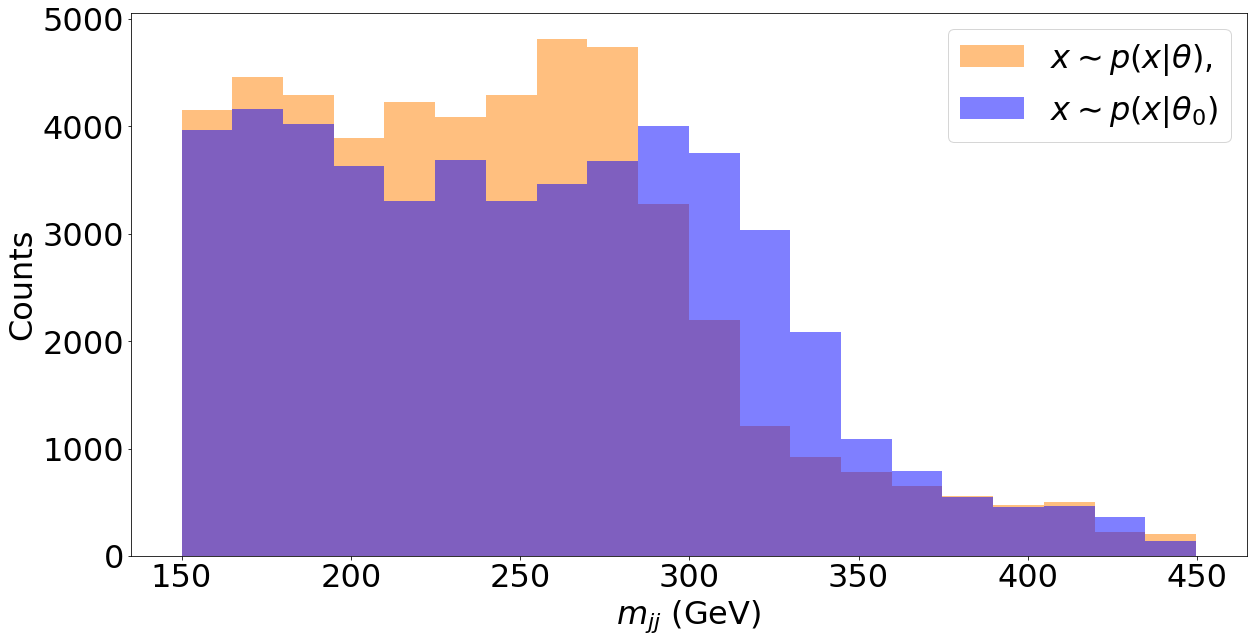

In [5]:
binsize=20

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 32})
plt.hist(invm[np.where(y[:,0] == 0)[0]], fc=(1, .5, 0, 0.5), bins=binsize)
plt.hist(invm[np.where(y[:,0] == 1)[0]],  fc=(0, 0, 1, 0.5), bins=binsize)
plt.gca().legend((r'$x\sim p(x|\theta)$, ',r'$x\sim p(x|\theta_0)$'), prop={'size': 32})
plt.xlabel(r'$m_{jj}$ (GeV)')
plt.ylabel('Counts')
plt.savefig('figures/toy_invm_histogram.png', format='png')
#plt.savefig('figures/toy_invm_histogram.svg', format='svg')
plt.show()

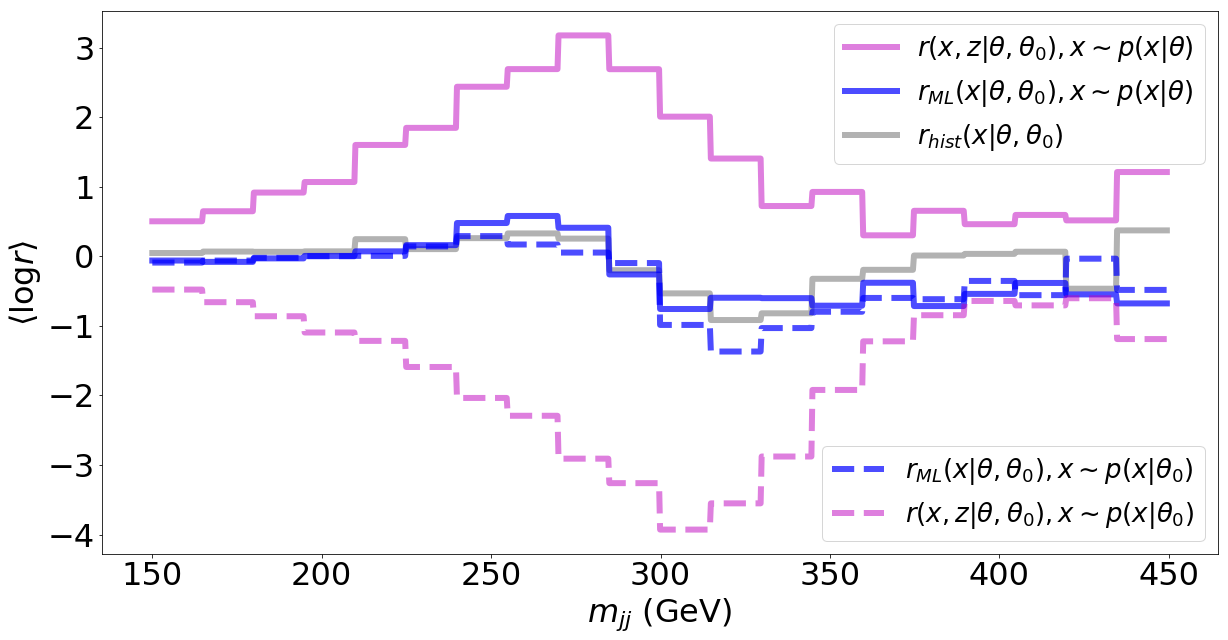

In [6]:
r_x_hist_numerator, bin_edges = np.histogram(invm[np.where(y[:,0] == 0)[0]], bins=binsize)
r_x_hist_denominator,_ = np.histogram(invm[np.where(y[:,0] == 1)[0]], bins=binsize)
r_x_hist = r_x_hist_numerator / r_x_hist_denominator.astype(np.float32)

rx_domain = np.linspace(bin_edges[0], bin_edges[-1], 1001)
rx_domain = rx_domain[:-1]
rx_hist_plot = increase_bin_points(rx_domain, bin_edges, r_x_hist)

# Points drawn from theta theory.
invm_temp = invm[np.where(y[:,0] == 0)[0]]

log_r_hat_xtheta = log_r_hat_x[0, np.where(y[:,0] == 0)[0]]
log_rxz_xtheta = np.log(r_xz[np.where(y[:,0] == 0)[0]])

med_rxml_theta = evaluate_avg_within_each_bin(invm_temp, log_r_hat_xtheta, bin_edges)
med_rxml_theta_plot = increase_bin_points(rx_domain, bin_edges, med_rxml_theta)

med_rxz_theta = evaluate_avg_within_each_bin(invm_temp, log_rxz_xtheta, bin_edges)
med_rxz_theta_plot = increase_bin_points(rx_domain, bin_edges, med_rxz_theta)

# Now points drawn from theta0 theory
invm_temp = invm[np.where(y[:,0] == 1)[0]]

log_r_hat_theta0 = log_r_hat_x[0, np.where(y[:,0] == 1)[0]]
log_rxz_theta0 = np.log(r_xz[np.where(y[:,0] == 1)[0]])

med_rxml_theta0 = evaluate_avg_within_each_bin(invm_temp, log_r_hat_theta0, bin_edges)
med_rxml_theta0_plot = increase_bin_points(rx_domain, bin_edges, med_rxml_theta0)

med_rxz_theta0 = evaluate_avg_within_each_bin(invm_temp, log_rxz_theta0, bin_edges)
med_rxz__theta0_plot = increase_bin_points(rx_domain, bin_edges, med_rxz_theta0)

fig, ax = plt.subplots(1, figsize=[20,10])
# Plot Histogram r(mjj)
p1, =ax.plot(rx_domain, np.log(rx_hist_plot), 'k-', linewidth=6.0, alpha=0.3, label = r'$r_{hist}(m_{jj}|\theta, \theta_0)$')
# Plot ML r(x)
p2, =ax.plot(rx_domain, med_rxml_theta_plot, 'b-', linewidth=6.0, alpha=0.7, label = r'$\langle r_{ML}(x|\theta, \theta_0) \rangle_{x\sim p(x|\theta)}$')
p3, =ax.plot(rx_domain, med_rxml_theta0_plot, 'b--', linewidth=6.0, alpha=0.7, label = r'$\langle r_{ML}(x|\theta, \theta_0) \rangle_{x\sim p(x|\theta_0)}$')
# Plot joint r(x,z)
p4, =ax.plot(rx_domain, med_rxz_theta_plot, 'm-', linewidth=6.0, alpha=0.5, label = r'$\langle r(x,z|\theta, \theta_0)\rangle_{x\sim p(x|\theta)}$')
p5, =ax.plot(rx_domain, med_rxz__theta0_plot, 'm--', linewidth=6.0, alpha=0.5, label = r'$\langle r(x,z|\theta, \theta_0)\rangle_{x\sim p(x|\theta_0)}$')

l1 = legend([p4,p2,p1], [r'$r(x,z|\theta, \theta_0), x\sim p(x|\theta)$', r'$r_{ML}(x|\theta, \theta_0), x\sim p(x|\theta)$', r'$r_{hist}(x|\theta, \theta_0)$'], loc='upper right',prop={'size': 26})
l2 = legend([p3, p5], [r'$r_{ML}(x|\theta, \theta_0), x\sim p(x|\theta_0)$', r'$r(x,z|\theta, \theta_0), x\sim p(x|\theta_0)$'], loc='lower right', prop={'size': 26})
plt.gca().add_artist(l1)
plt.plot()
plt.xlabel(r'$m_{jj}$ (GeV)')
plt.ylabel(r'$\langle \log r \rangle$')
plt.savefig('figures/toy_r_comparison.png', format='png')
#plt.savefig('figures/toy_r_comparison.svg', format='svg')
plt.show()